<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
</center>
Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

In [41]:
import numpy as np
import copy
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [42]:
RANDOM_STATE = 17

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [170]:
def entropy(y):  
    s = 0
    for i in np.unique(y):
        p = np.sum((i == y))/y.shape[0]
        s+=p*np.log2(p)
    
    return s*(-1)

def gini(y):
    sum_p = 0
    for i in np.unique(y):
        p = np.sum((i == y))/y.shape[0]
        sum_p+=p*p
    return 1-sum_p

def variance(y):
    
    mean = np.mean(y)
    sum_mean = 0
    for i in y:
        sum_mean+=np.square(i-mean)
    
    return sum_mean/y.shape[0]

def mad_median(y):
    median = np.median(y)
    sum_median = 0
    for i in y:
        sum_median+=np.abs(i-median)
    
    return sum_median/y.shape[0]

## Тестирование реализованного алгоритма

In [203]:
class Tree:
    def __init__(self):
        self.left = None
        self.right = None
        self.splitting_feature = None
        self.splitting_values = None
        self.information = None
        self.values_pred = None
        self.depth = None   

### Классификация

In [213]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
        
        self.max_depth = max_depth
        self.__max_depth_cnt__ = 0
        self.min_samples_split = min_samples_split
        self.debug = debug   
        self.criterion = criterion 
        self.__tree__ = Tree()
        self.__targe_unique__ = None
        
    # Подсчет информативнисти
    def __calculation_information__(self, y):
        if self.criterion == 'gini':
            return gini(y)
        elif self.criterion == 'entropy':
            return entropy(y)
        
    #Раздаление numpy матрицы 
    def __split__(self, arr, cond):
        return (arr[cond], arr[~cond])

        
    # Прирорст информации   
    def __information_gain__(self,information, left, right):
        base = left.shape[0] + right.shape[0]
        return information-(
            (left.shape[0]/base*self.__calculation_information__(left))+(right.shape[0]/base*self.__calculation_information__(right)))
    
    def __tree_creation__(self, tree, X, y, depth_cnt):
        
        # Сохраняем значения у 
        tree.values_pred = copy.deepcopy(y)
        
        # Информативность текущего узла 
        tree.information = self.__calculation_information__(y)
        
        
        # Проверка глубины
        if self.max_depth == depth_cnt:
            return 
        
        # Увеличиваем глубину
        depth_cnt+=1
        tree.depth = copy.deepcopy(depth_cnt)
        
        # Проверка значения хаоса
        if tree.information == 0:
            return 
        
        # Проверка глубины
        if self.min_samples_split >= X.shape[0]:
            return 
        
        # Добавление столбца таргет к признакам
        x = np.column_stack((X, y.reshape((-1, 1))[:, 0]))
        
        # Поиск условия с максимальным приростом информации
        best_gain = 0
        best_feature = 0 
        best_val = None

        for feature in range(x.shape[1]-1):
            for val in np.unique(x[:,feature]):
                (left, right) = self.__split__(x,x[:,feature]<val)

                # Условие для исключения пустых потомков
                if left[:,-1].shape[0]!=0 and left[:,-1].shape[0]!=0:
                    next_gain = self.__information_gain__(tree.information, left[:,-1], right[:,-1])
                    if best_gain < next_gain:
                        best_gain = copy.deepcopy(next_gain)
                        best_feature = copy.deepcopy(feature)
                        best_val = copy.deepcopy(val)

        if best_val is None:
            best_val = x[:,best_feature].max()
            
        # Сохраняем условия разделения выборки 
        tree.splitting_feature = copy.deepcopy(best_feature)
        tree.splitting_values = copy.deepcopy(best_val)
        
        (left, right) = self.__split__(x,x[:,best_feature]<best_val)
        
              
        # Разбиваем левого потомка 
        tree.left = Tree()
        self.__tree_creation__(tree=tree.left, X=left[:,:-1], y=left[:,-1], depth_cnt=tree.depth)
        
        # Разбиваем правого потомка 
        tree.right = Tree()
        self.__tree_creation__(tree=tree.right, X=right[:,:-1], y=right[:,-1], depth_cnt=tree.depth)
        
        
    def fit(self, X, y): 
        self.__targe_unique__ = np.unique(y)
        self.__tree_creation__(tree=self.__tree__, X=X, y=y, depth_cnt=self.__max_depth_cnt__)    
    
    def __predict_tree__(self, tree, x):
        
        # Проверка на попадание в лист дерева
        if tree.right is None and tree.left is None:            
            return tree.values_pred
        
        # Проверка условий для левого потомка дерева
        if x[tree.splitting_feature]<tree.splitting_values:
            if tree.left is None:
                return tree.values_pred
            return self.__predict_tree__(tree.left, x)
        
        # Проверка условий для правого потомка дерева 
        else:
            if tree.right is None:
                return tree.values_pred
            return self.__predict_tree__(tree.right, x)
        
    
    def predict(self, X):
        pred = []
        for i in X:
            y = self.__predict_tree__(self.__tree__, i)
            pred.append(stats.mode(y).mode[0])
        return np.array(pred)
        
        
    def predict_proba(self, X):
        pred_prod = np.array([self.__targe_unique__])
        
        for i in X:
            y = self.__predict_tree__(self.__tree__, i)
            pred = np.array([])
            for class_select in self.__targe_unique__:
                class_cnt = np.sum((class_select == y))
                pred = np.append(pred, round(class_cnt/y.shape[0], 4))
       
            pred_prod = np.vstack([pred_prod, pred])
            
        return np.array(pred_prod[1:])
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
#         pred = self.predict(X)
#         return sum((pred == y))/y.shape[0]


С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [214]:
# Ваш код здесь
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

(1797, 64)


In [215]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=17)

In [16]:
%%time

model = DecisionTree(max_depth=100)
model.fit(X_train, y_train)

Wall time: 10.4 s


In [17]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       0.79      0.76      0.78        34
           2       0.82      0.82      0.82        34
           3       0.82      0.71      0.76        38
           4       0.89      0.82      0.86        40
           5       0.80      0.95      0.87        41
           6       0.88      0.88      0.88        32
           7       0.80      0.90      0.85        31
           8       0.76      0.69      0.72        36
           9       0.78      0.78      0.78        40

    accuracy                           0.82       360
   macro avg       0.83      0.83      0.82       360
weighted avg       0.83      0.82      0.82       360



С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [216]:
# Ваш код здесь
kfold = 5

tree_params = {'max_depth': range(3,11),
              'criterion':['entropy', 'gini']}

model = DecisionTree()
tree_grid = GridSearchCV(model, tree_params, cv=kfold, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

tree_grid.best_params_,tree_grid.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished


({'criterion': 'entropy', 'max_depth': 8}, 0.865701219512195)

In [217]:
print(classification_report(y_test, tree_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        34
           1       0.87      0.79      0.83        34
           2       0.86      0.88      0.87        34
           3       0.86      0.82      0.84        38
           4       0.82      0.93      0.87        40
           5       0.95      0.90      0.92        41
           6       0.93      0.84      0.89        32
           7       0.86      0.97      0.91        31
           8       0.86      0.89      0.88        36
           9       0.90      0.90      0.90        40

    accuracy                           0.89       360
   macro avg       0.89      0.89      0.89       360
weighted avg       0.89      0.89      0.89       360



Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

In [221]:
import pandas as pd 

In [222]:
# Ваш код здесь
df_plot = pd.DataFrame(tree_grid.cv_results_['params'])
df_plot['accuracy'] = tree_grid.cv_results_['mean_test_score']

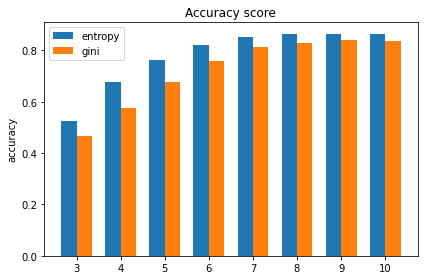

In [223]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = df_plot.max_depth.sort_values().unique()
entropy = df_plot[df_plot.criterion=='entropy'].sort_values('max_depth').accuracy
gini = df_plot[df_plot.criterion=='gini'].sort_values('max_depth').accuracy

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, entropy, width, label='entropy')
rects2 = ax.bar(x + width/2, gini, width, label='gini')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('Accuracy score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

**Выберите верные утверждения:**
1. Оптимальное значение `max_depth` для каждого критерия достигается на отрезке [4, 9].
2. На отрезке [3, 10] построенные графики не пересекаются.
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз.
4. Наилучшее качество при `max_depth` на интервале [3, 10] достигается при использовании критерия `gini`.
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения `max_depth` на интервале [3, 10]. (max_depth = 10 у ниже чем у max_depth = 9)

In [ ]:
# Ответ:
#     1. Оптимальное значение max_depth для каждого критерия достигается на отрезке [4, 9] (tree_grid.best_params_ =  'max_depth': 8)
#     2. На отрезке [3, 10] построенные графики не пересекаются.

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

In [ ]:
# Ответ:
#     ни один из перечисленных 
#     max_depth = 8, criterion = 'entropy';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [225]:
def entropy(y):  
    s = 0
    for i in np.unique(y):
        p = np.sum((i == y))/y.shape[0]
        s+=p*np.log2(p)
    
    return s*(-1)


model = DecisionTree(max_depth=8, criterion='entropy')
model.fit(X_train, y_train)

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

In [226]:
np.mean(model.predict_proba(X_test))

0.10000033333333334

**Вопрос:** Чему примерно равна максимальная вероятность в полученном векторе?
1. 0.127
2. 0.118
3. 1.0
4. 0.09

In [229]:
# Ответ:
#     ~0.09

### Регрессия

In [199]:
class DecisionTreeReg(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='variance', debug=False):
        
        self.max_depth = max_depth
        self.__max_depth_cnt__ = 0
        self.min_samples_split = min_samples_split
        self.debug = debug   
        self.criterion = criterion 
        self.__tree__ = Tree()
        
    # Подсчет информативнисти
    def __calculation_information__(self, y):
        if self.criterion == 'variance':
            return variance(y)
        elif self.criterion == 'mad_median':
            return mad_median(y)
        
    #Раздаление numpy матрицы 
    def __split__(self, arr, cond):
        return (arr[cond], arr[~cond])

        
    # Прирорст информации   
    def __information_gain__(self, information, left, right):
        base = left.shape[0] + right.shape[0]
        return information-(
            ((left.shape[0]/base)*self.__calculation_information__(left))+((right.shape[0]/base)*self.__calculation_information__(right)))
    
    def __tree_creation__(self, tree, X, y, depth_cnt):
        
        # Сохраняем значения у 
        tree.values_pred = copy.deepcopy(y)
        
        # Информативность текущего узла 
        tree.information = self.__calculation_information__(y)
        
        # Проверка глубины
        if self.max_depth == depth_cnt:
            return 
        
        # Увеличиваем глубину
        depth_cnt+=1
        tree.depth = copy.deepcopy(depth_cnt)
        
        # Проверка значения хаоса
        if tree.information == 0:
            return 
        
        # Проверка глубины
        if self.min_samples_split >= X.shape[0]:
            return 
        
        # Добавление столбца таргет к признакам
        x = np.column_stack((X, y.reshape((-1, 1))[:, 0]))
        
        # Поиск условия с максимальным приростом информации
        best_gain = 0
        best_feature = 0 
        best_val = None
        
        for feature in range(x.shape[1]-1):
            for val in np.unique(x[:,feature]):
                (left, right) = self.__split__(x,x[:,feature]<val)
                
                # Условие для исключения пустых потомков
                if left[:,-1].shape[0]!=0 and left[:,-1].shape[0]!=0:
                    next_gain = self.__information_gain__(tree.information, left[:,-1], right[:,-1])
                    if best_gain < next_gain:
                        best_gain = copy.deepcopy(next_gain)
                        best_feature = copy.deepcopy(feature)
                        best_val = copy.deepcopy(val)

        if best_val is None:
            best_val = x[:,best_feature].max()
            
        # Сохраняем условия разделения выборки 
        tree.splitting_feature = copy.deepcopy(best_feature)
        tree.splitting_values = copy.deepcopy(best_val)
        
        (left, right) = self.__split__(x,x[:,best_feature]<best_val)
        
        # Разбиваем левого потомка 
        tree.left = Tree()
        self.__tree_creation__(tree=tree.left, X=left[:,:-1], y=left[:,-1], depth_cnt=tree.depth)
        
        # Разбиваем правого потомка 
        tree.right = Tree()
        self.__tree_creation__(tree=tree.right, X=right[:,:-1], y=right[:,-1], depth_cnt=tree.depth)
        
        
    def fit(self, X, y): 
        self.__tree_creation__(tree=self.__tree__, X=X, y=y, depth_cnt=self.__max_depth_cnt__)    
    
    
    def __predict_tree__(self, tree, x):

        # Проверка на попадание в лист дерева
        if tree.right is None and tree.left is None:
            return tree.values_pred
        
        # Проверка условий для левого потомка дерева
        if x[tree.splitting_feature]<tree.splitting_values:
            if tree.left is None:
                return tree.values_pred
            return self.__predict_tree__(tree.left, x)
        
        # Проверка условий для правого потомка дерева 
        else:
            if tree.right is None:
                return tree.values_pred
            return self.__predict_tree__(tree.right, x)
        

    
    def predict(self, X):
        pred = []
        for i in X:
            y = self.__predict_tree__(self.__tree__, i)
            pred.append(np.mean(y))
        return np.array(pred)
        
    
    def score(self, X, y):
        return mean_squared_error(y, self.predict(X))
    


С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [196]:
# Ваш код здесь
boston  = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.2, random_state=17)

In [206]:
model = DecisionTreeReg(criterion='variance')
model.fit(X_train, y_train)
model.score(X_test, y_test)

11.382647058823528

In [205]:
model = DecisionTreeReg(criterion='mad_median')
model.fit(X_train, y_train)
model.score(X_test, y_test)

15.262622549019609

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [207]:
# Ваш код здесь
kfold = 5

tree_params = {'max_depth': range(2,9),
              'criterion':['variance', 'mad_median']}

model = DecisionTreeReg()
tree_grid = GridSearchCV(model, tree_params, cv=kfold, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

tree_grid.best_params_,tree_grid.best_score_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.4min finished


({'criterion': 'mad_median', 'max_depth': 2}, 32.92907196820363)

Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

In [209]:
# Ваш код здесь
df_plot = pd.DataFrame(tree_grid.cv_results_['params'])
df_plot['accuracy'] = tree_grid.cv_results_['mean_test_score']

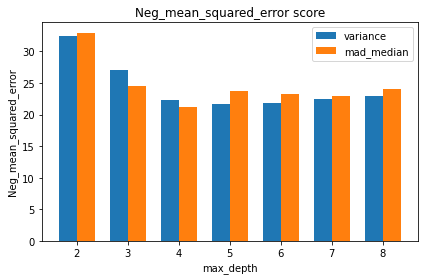

In [212]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = df_plot.max_depth.sort_values().unique()
variance = df_plot[df_plot.criterion=='variance'].sort_values('max_depth').accuracy
mad_median = df_plot[df_plot.criterion=='mad_median'].sort_values('max_depth').accuracy

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, variance, width, label='variance')
rects2 = ax.bar(x + width/2, mad_median, width, label='mad_median')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Neg_mean_squared_error')
ax.set_xlabel('max_depth')
ax.set_title('Neg_mean_squared_error score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. Оптимальное значение `max_depth` для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при `max_depth` из [2, 8] достигается при использовании критерия `mad_median`.

In [ ]:
# Ответ:
#     3. Оптимальное значение max_depth для каждого из критериев достигается на границе отрезка [2, 8].
#     4. Наилучшее качество при max_depth из [2, 8] достигается при использовании критерия mad_median.

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance';